In [1]:
import numpy as np
import pandas as pd
import pickle
import os, glob
import logging
import seaborn as sns

In [2]:
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.recurrent import LSTM

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [4]:
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
path = os.getcwd()
path

'/home/m.shah/projects/models/kaggle-models'

## Loading Data

In [8]:
dfs = []

for filename in glob.glob(os.path.join(path, "../../data/simulated-data-raw/", "data", "*.pkl")):
    with open(filename, 'rb') as f:
        temp = pd.read_pickle(f)
        dfs.append(temp)
df = pd.DataFrame()
df = df.append(dfs)
df = df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 8, 7]]

In [9]:
df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD_SCENARIO,TX_FRAUD
0,0,2018-04-01 00:00:31,596,3156,57.16,31,0,0,0
1,1,2018-04-01 00:02:10,4961,3412,81.51,130,0,0,0
2,2,2018-04-01 00:07:56,2,1365,146.00,476,0,0,0
3,3,2018-04-01 00:09:29,4128,8737,64.49,569,0,0,0
4,4,2018-04-01 00:10:34,927,9906,50.99,634,0,0,0


## Preprocessing

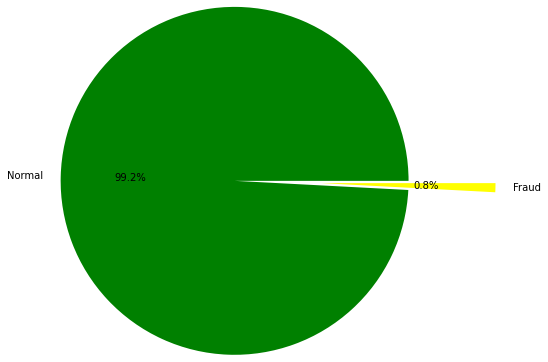

In [8]:
portions = df["TX_FRAUD"].value_counts().to_dict()
plt.pie(portions.values(), 
        portions.keys(),
        labels = ["Normal", "Fraud"], 
        radius = 2,
        autopct='%1.1f%%',
       colors = ["green", "yellow"])
plt.show()

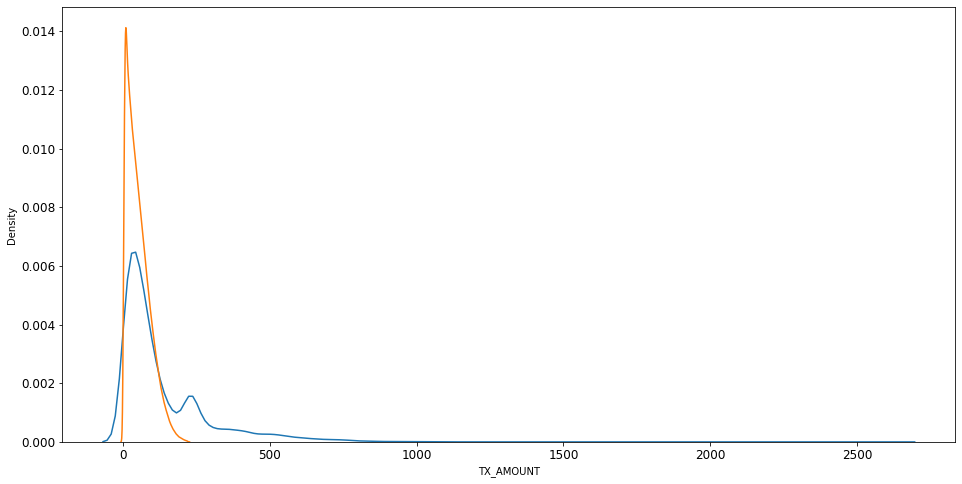

In [10]:
feature = 'TX_AMOUNT'
plt.figure(figsize = (16, 8))
sns.kdeplot(data = df.loc[df['TX_FRAUD'] == 1]['TX_AMOUNT'])
sns.kdeplot(data = df.loc[df['TX_FRAUD'] == 0]['TX_AMOUNT'])
plt.xlabel(feature, fontsize=10)
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

In [11]:
customer_tx_count = df["CUSTOMER_ID"].value_counts().to_dict()

<AxesSubplot:ylabel='Density'>

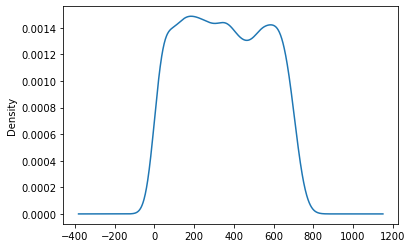

In [12]:
pd.Series(list(customer_tx_count.values())).plot(kind = 'density')

In [14]:
class Preprocessor:    
    def __init__(self, input_data):
        self.data = input_data
    
    def pre_process(self, 
                    feature_columns,
                    label_columns,
                    window_size = 128,
                    numericals = None,
                    categoricals = None,
                    test_train_split = 0.7,
                    imbalanced = False):
        # ---------- 
        self.window_size = window_size
        self.test_train_split = test_train_split
        self.x_tensor = pd.DataFrame(self.data[feature_columns], dtype = 'float32')
        self.y_tensor = pd.DataFrame(self.data[label_columns], dtype = 'float32')
        self.n_features = len(feature_columns)
        self.n_labels = len(label_columns)
        # ---------- Categorical features, OneHotEncoding
        print(self.x_tensor.shape)
        if categoricals is not None:
            self.encode(categoricals)
            with open("./log.txt", 'a') as log:
                log.write("- - - - Categorical features Encoded - - - -\n")
        print(self.x_tensor.shape)
        # ---------- Standardization
        self.scaler(numericals)
        
        
        # ---------- Rolling X and Y Tensors
#         print("======== Making X and Y Tensors ==========")
#         self.x_tensor, self.y_tensor = self.roll(self.window_size)
#         print("Input X by shape:", self.data_x.shape,"is rolled to X Tensor: ", self.x_tensor.shape)
#         with open("./log.txt", 'a') as log:
#             log.write("X and Y tensors are Rolled \n")

        self.train_idx = np.random.choice(self.x_tensor.shape[0], 
                                      int(self.x_tensor.shape[0]*self.test_train_split), replace=False)
                      
        self.X_train = self.x_tensor[self.train_idx, :, :]
        self.X_test = np.delete(self.x_tensor, self.train_idx, axis=0)
        self.y_train = self.y_tensor[self.train_idx, ]
        self.y_test = np.delete(self.y_tensor, self.train_idx, axis=0)
        with open("./log.txt", 'a') as log:
            log.write("Preprocessing Done! \n")

        return self.X_train, self.X_test, self.y_train, self.y_test
                
    def encode(self, categoricals):
        if categoricals[0] is not None:
            self.x_tensor = pd.get_dummies(self.x_tensor, columns = categoricals[0])
            self.n_features = self.x_tensor.shape[1]
        if categoricals[1] is not None:
            self.y_tensor = pd.get_dummies(self.y_tensor, columns = categoricals[1])
    
    def scaler(self, numericals):
        scaler = MinMaxScaler()
        self.x_tensor[numericals[0]] = scaler.fit_transform(self.x_tensor[numericals[0]])
        self.x_tensor[numericals[1]] = scaler.fit_transform(self.y_tensor[numericals[1]])

In [23]:
#Feature Define
if "WEEK_DAY" not in df.columns:
    df.insert(7, "WEEK_DAY", df["TX_DATETIME"].apply(lambda x : x.weekday()))

#Feature Selection
selected_features = ["CUSTOMER_ID", 
                     "TERMINAL_ID", 
                     'TX_AMOUNT', 
                     'TX_TIME_SECONDS', 
                     'TX_TIME_DAYS', 
                     "WEEK_DAY"]

In [49]:
prep.train_idx.shape, prep.x_tensor.shape

((1403324,), (1754155, 6))

In [52]:
np.delete(prep.x_tensor, [1, 2])

ValueError: Shape of passed values is (10524928, 1), indices imply (1754155, 6)

In [41]:
prep = PreProcessor(df.iloc[:, :9])
prep.pre_process(selected_features, label_columns = selected_features)

(1403324,)
[ 575490 1406884 1646374 ... 1489323  472986   20346]


ValueError: Shape of passed values is (350831, 6), indices imply (1754155, 6)

In [18]:
class VAE_FRAUD_DETECTOR:
    def __init__(self, 
                input_shape,
                enc_layers = [100, 50],
                dec_layers = [50, 100],
                enc_activation = 'relu',
                dec_activation = 'tanh'):
        self.input_shape = input_shape
        #Input layer
        input_x = Input(shape = self.input_shape)
        x = Dense(enc_layers[0], activation = enc_activation[0])
        # Encoder
        for i in range(1, len(enc_layers)):
            x = Dense(enc_layers[i], activation = enc_activation)(x)
        # Decoder
        for i in range(dec_layers):
            x = Dense(dec_layers[i], dec_activation)
        output_y = Dense(shape = output_shape)(x)
        self.model = Model(input_x, output_y)
        self.model.compile(loss = 'mse', optimizer = 'adam')
        self.model.summary()
        self.model
    def train(self, train_x, train_y, test_x, test_y, batch_size = 128, epochs = 100):
        self.model.fit(train_x, train_y,
                       batch_size = batch_size,
                       epochs = epochs,
                       validation_split = 0.2)    

In [19]:
pre = Pre

(1754155, 9)